In [2]:
import sys
print(sys.executable)

c:\Program Files\Python311\python.exe


In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.20.0
Num GPUs Available: 0


In [1]:
# Then import the required libraries
import importlib
import numpy as np
import os
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
# Remove standalone keras imports and use tf.keras instead
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# Update keras imports to use tf.keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
# Use tf.keras.models instead
from sklearn.model_selection import GridSearchCV
import joblib

In [2]:
seed = 0
np.random.seed(seed)

df = pd.read_csv('gene_level_methylation.csv')

print("Original columns:", df.columns.tolist()[:10], "...")

# Remove the "SingleValueType" column if it exists
if "SingleValueType" in df.columns:
    df = df.drop(columns=["SingleValueType"])
    print("Column 'SingleValueType' has been removed successfully.")
else:
    print("Column 'SingleValueType' does not exist in the DataFrame.")

# Sort columns and transpose
df = df.reindex(sorted(df.columns), axis=1)
df = df.T

# Set first row (originally "GeneSymbol") as new column names
df.columns = df.iloc[0]  # first row becomes column headers
df = df.drop(df.index[0])  # drop the first row

print("CNV Matrix After Transpose and Header Fix:", df.shape)
print("\nDataFrame preview:")
df.head()

Original columns: ['GeneSymbol', 'SingleValueType', 'TCGA-OL-A66H-01', 'TCGA-3C-AALK-01', 'TCGA-AC-A5EH-01', 'TCGA-EW-A2FW-01', 'TCGA-E9-A1R0-01', 'TCGA-AR-A1AJ-01', 'TCGA-AC-A62Y-01', 'TCGA-E9-A1QZ-01'] ...
Column 'SingleValueType' has been removed successfully.
CNV Matrix After Transpose and Header Fix: (888, 19277)

DataFrame preview:


GeneSymbol,RPS4Y2,RPS4Y1,TBL1Y,NLGN4Y,PRKY,PCDH11Y,TTTY20,GABRE,FTHL17,PORCN,...,EP300,DERL3,PLA2G3,TMPRSS6,MIR1281,GGT3P,UBE2L3,APOL5,SLC5A1,CDC42EP1
TCGA-3C-AAAU-01,0.527,0.57214,0.447925,0.052075,0.1233,0.0581,0.50125,0.377325,0.878033,0.365011,...,0.099,0.04835,0.7942,0.86505,0.099,0.8638,0.3368,0.928,0.1865,0.0178
TCGA-3C-AALI-01,0.6489,0.5074,0.426008,0.07245,0.8148,0.0836,0.473473,0.387325,0.758033,0.254889,...,0.0617,0.38345,0.7698,0.8228,0.0617,0.8317,0.8098,0.8742,0.8993,0.0234
TCGA-3C-AALJ-01,0.6949,0.563733,0.464233,0.0675,0.7933,0.0627,0.45565,0.333725,0.6283,0.473433,...,0.075,0.4813,0.7681,0.8433,0.075,0.7911,0.44875,0.8888,0.739,0.031
TCGA-3C-AALK-01,0.5778,0.5722,0.50945,0.34105,0.6853,0.2694,0.5769,0.53885,0.9241,0.417256,...,0.0856,0.5369,0.7532,0.83555,0.0856,0.8151,0.3113,0.9321,0.763,0.0274
TCGA-4H-AAAK-01,0.4716,0.5077,0.45365,0.063675,0.6571,0.3482,0.438033,0.480625,0.9169,0.469724,...,0.0808,0.1768,0.6704,0.7699,0.0808,0.8049,0.2855,0.937,0.7207,0.0268


In [8]:
#all genes

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, ReLU, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

# -------------------------------
# CONFIGURATION
# -------------------------------
seed = 0
np.random.seed(seed)

# Load data
X_train = pd.read_csv("X_train_Norway.csv")
X_test = pd.read_csv("X_test_Norway.csv")
y_train = pd.read_csv("y_train_Norway.csv").values.ravel()
y_test = pd.read_csv("y_test_Norway.csv").values.ravel()


# Label encode
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
n_classes = len(le.classes_)

# IRUS
sm = RandomUnderSampler(random_state=seed)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train_enc)

# One-hot encode labels
y_train_oh = to_categorical(y_train_sm, num_classes=n_classes)
y_test_oh = to_categorical(y_test_enc, num_classes=n_classes)

input_dim = X_train_sm.shape[1]

# -------------------------------
# AUTOENCODER (fixed)
# -------------------------------
def build_autoencoder(input_dim, encoding_dim=500, hidden_dim1=5000, hidden_dim2=2000, 
                      l2_reg=1e-14, learning_rate=3e-5):
    """Build encoder + autoencoder"""
    inp = Input(shape=(input_dim,))
    x = Dense(hidden_dim1, kernel_regularizer=regularizers.l2(l2_reg))(inp)
    x = ReLU()(x)
    x = Dense(hidden_dim2, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = ReLU()(x)
    encoded = Dense(encoding_dim, kernel_regularizer=regularizers.l2(l2_reg))(x)
    encoded = ReLU()(encoded)
    
    # Decoder
    x = Dense(hidden_dim2, kernel_regularizer=regularizers.l2(l2_reg))(encoded)
    x = ReLU()(x)
    x = Dense(hidden_dim1, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = ReLU()(x)
    decoded = Dense(input_dim, activation='linear')(x)
    
    autoencoder = Model(inputs=inp, outputs=decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['accuracy'])
    
    encoder = Model(inputs=inp, outputs=encoded)
    return autoencoder, encoder

autoencoder, encoder = build_autoencoder(input_dim)
autoencoder.fit(X_train_sm, X_train_sm, epochs=100, batch_size=32, verbose=1, shuffle=True)

# Encode features
X_train_encoded = encoder.predict(X_train_sm)
X_test_encoded = encoder.predict(X_test)

# -------------------------------
# CLASSIFIER
# -------------------------------
def create_classifier(hidden_dim=200, dropout_rate1=0.2, dropout_rate2=0.3, 
                      learning_rate=2e-5, activation='relu', regularization=None):
    inp = Input(shape=(X_train_encoded.shape[1],))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rate1, seed=seed)(x)
    
    if regularization == 'l1':
        reg = regularizers.l1(1e-14)
    elif regularization == 'l2':
        reg = regularizers.l2(1e-14)
    elif regularization == 'l1_l2':
        reg = regularizers.l1_l2(1e-14, 1e-14)
    else:
        reg = None

    if activation == 'leakyrelu':
        x = Dense(hidden_dim, kernel_regularizer=reg)(x)
        x = LeakyReLU(alpha=0.01)(x)
    elif activation == 'relu':
        x = Dense(hidden_dim, kernel_regularizer=reg)(x)
        x = ReLU()(x)
    else:  # tanh
        x = Dense(hidden_dim, activation='tanh', kernel_regularizer=reg)(x)

    x = BatchNormalization()(x)
    x = Dropout(dropout_rate2, seed=seed)(x)
    out = Dense(n_classes, activation='softmax')(x)
    
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap with KerasClassifier for RandomizedSearchCV
clf = KerasClassifier(
    model=create_classifier,
    epochs=100,
    verbose=0,
    random_state=seed,
)

# -------------------------------
# RANDOMIZED SEARCH
# -------------------------------
param_dist = {
    'hidden_dim': [200],
    'dropout_rate1': [0.1, 0.2, 0.3],
    'dropout_rate2': [0.1, 0.2, 0.3, 0.4, 0.5],
    'learning_rate':  [0.01, 0.002, 0.001, 0.0001],
    'activation': ['relu', 'tanh', 'leakyrelu'],
    'regularization': [None, 'l1', 'l2', 'l1_l2'],
    'batch_size': [16, 32, 64]
}

random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=50, 
                                   scoring='f1_weighted', cv=3, random_state=seed, verbose=2)

start = time.time()
random_search.fit(X_train_encoded, y_train_sm)
end = time.time()
print(f"RandomizedSearchCV completed in {(end-start)/60:.2f} minutes")

# -------------------------------
# EVALUATION
# -------------------------------
best_model = random_search.best_estimator_

# Predict
y_pred_classes = best_model.predict(X_test_encoded)
print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred_classes, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test_enc, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - RandomizedSearchCV Best Model')
plt.tight_layout()
plt.show()


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.0000e+00 - loss: 0.1876
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0000e+00 - loss: 0.1824
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0000e+00 - loss: 0.1709
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0000e+00 - loss: 0.1499
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0000e+00 - loss: 0.1218
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0000e+00 - loss: 0.0935
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0000e+00 - loss: 0.0668
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0000e+00 - loss: 0.0448
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0000e+00 - loss: 0.0299
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0000e+00 - loss: 0.0211
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0000e+00 - loss: 0.0158
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - a

ValueError: Invalid parameter regularization for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(regularization=l1_l2)`
Check the list of available parameters with `estimator.get_params().keys()`

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV] END batch_size=16, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.1, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1_l2; total time=   4.7s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\mike

[CV] END batch_size=16, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.1, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1_l2; total time=   4.7s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=None; total time=   4.6s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=None; total time=   4.7s
[CV] END batch_size=64, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1_l2; total time=   4.4s
[CV] END batch_size=64, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1_l2; total time=   4.4

C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\mike

[CV] END batch_size=32, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1_l2; total time=   4.4s
[CV] END batch_size=32, model__activation=tanh, model__dropout_rate1=0.3, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=None; total time=   4.3s
[CV] END batch_size=32, model__activation=tanh, model__dropout_rate1=0.3, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=None; total time=   4.3s
[CV] END batch_size=32, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1_l2; total time=   4.4s
[CV] END batch_size=32, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1_l2; total time=   4.4s
[CV

C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\mike

[CV] END batch_size=32, model__activation=tanh, model__dropout_rate1=0.3, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1_l2; total time=   4.4s
[CV] END batch_size=32, model__activation=tanh, model__dropout_rate1=0.2, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=None; total time=   4.3s
[CV] END batch_size=32, model__activation=tanh, model__dropout_rate1=0.2, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=None; total time=   4.3s
[CV] END batch_size=32, model__activation=tanh, model__dropout_rate1=0.2, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l2; total time=   4.4s
[CV] END batch_size=32, model__activation=tanh, model__dropout_rate1=0.2, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l2; total time=   4.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\mike

[CV] END batch_size=16, model__activation=relu, model__dropout_rate1=0.1, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=None; total time=   4.5s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\mike

[CV] END batch_size=16, model__activation=relu, model__dropout_rate1=0.1, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=None; total time=   4.5s
[CV] END batch_size=16, model__activation=leakyrelu, model__dropout_rate1=0.2, model__dropout_rate2=0.1, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=None; total time=   4.5s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\mike

[CV] END batch_size=16, model__activation=leakyrelu, model__dropout_rate1=0.2, model__dropout_rate2=0.1, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=None; total time=   4.6s
[CV] END batch_size=64, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l2; total time=   4.4s
[CV] END batch_size=64, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l2; total time=   4.3s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1; total time=   4.6s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1; total time=   4.6s
[CV] E

C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\mike

[CV] END batch_size=32, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l1_l2; total time=   4.3s
[CV] END batch_size=64, model__activation=tanh, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l1_l2; total time=   4.3s
[CV] END batch_size=64, model__activation=tanh, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l1_l2; total time=   4.3s
[CV] END batch_size=16, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l2; total time=   4.5s
[CV] END batch_size=16, model__activation=leakyrelu, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l2; total time=   4.5s
[

C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\mike

[CV] END batch_size=64, model__activation=relu, model__dropout_rate1=0.1, model__dropout_rate2=0.1, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1; total time=   4.3s
[CV] END batch_size=64, model__activation=tanh, model__dropout_rate1=0.3, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l1; total time=   4.3s
[CV] END batch_size=64, model__activation=tanh, model__dropout_rate1=0.3, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l1; total time=   4.3s
[CV] END batch_size=32, model__activation=leakyrelu, model__dropout_rate1=0.1, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1; total time=   4.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\mike

[CV] END batch_size=32, model__activation=leakyrelu, model__dropout_rate1=0.1, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1; total time=   4.3s
[CV] END batch_size=32, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.1, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1_l2; total time=   4.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\mike

[CV] END batch_size=32, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.1, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l1_l2; total time=   4.3s
[CV] END batch_size=64, model__activation=relu, model__dropout_rate1=0.1, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l2; total time=   4.3s
[CV] END batch_size=64, model__activation=relu, model__dropout_rate1=0.1, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l2; total time=   4.3s
[CV] END batch_size=32, model__activation=relu, model__dropout_rate1=0.2, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1; total time=   4.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\mike

[CV] END batch_size=32, model__activation=relu, model__dropout_rate1=0.2, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1; total time=   4.3s
[CV] END batch_size=16, model__activation=leakyrelu, model__dropout_rate1=0.1, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=None; total time=   4.5s
[CV] END batch_size=16, model__activation=leakyrelu, model__dropout_rate1=0.1, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=None; total time=   4.5s
[CV] END batch_size=16, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.002, model__regularization=l1; total time=   4.5s
[CV] END batch_size=16, model__activation=relu, model__dropout_rate1=0.3, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.002, model__regularization=l1; total time=   4.5s
[CV] EN

C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\mike

[CV] END batch_size=32, model__activation=tanh, model__dropout_rate1=0.3, model__dropout_rate2=0.2, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l2; total time=   4.3s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.3, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l1_l2; total time=   4.6s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.3, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.001, model__regularization=l1_l2; total time=   4.8s
[CV] END batch_size=32, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1; total time=   4.4s
[CV] END batch_size=32, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.01, model__regularization=l1; total time=   4.4s
[CV] END batch_

C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\mike

[CV] END batch_size=32, model__activation=leakyrelu, model__dropout_rate1=0.2, model__dropout_rate2=0.4, model__hidden_dim=200, model__learning_rate=0.0001, model__regularization=l2; total time=   4.4s
[CV] END batch_size=32, model__activation=relu, model__dropout_rate1=0.1, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.002, model__regularization=l1; total time=   4.3s
[CV] END batch_size=32, model__activation=relu, model__dropout_rate1=0.1, model__dropout_rate2=0.5, model__hidden_dim=200, model__learning_rate=0.002, model__regularization=l1; total time=   4.3s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.002, model__regularization=None; total time=   4.6s
[CV] END batch_size=16, model__activation=tanh, model__dropout_rate1=0.1, model__dropout_rate2=0.3, model__hidden_dim=200, model__learning_rate=0.002, model__regularization=None; total time=   4.5s
[CV] END b

C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [       nan 0.         0.         0.         0.05454545        nan
 0.         0.         0.         0.04444444        nan 0.
 0.                nan        nan 0.         0.         0.
 0.         0.         0.                nan 0.         0.04444444
 0.         0.         0.                nan 0.                nan
        nan 0.                nan 0.05       0.         0.
 0.                nan 0.         0.         0.         0.
        nan 0.02222222 0.         0.05263158 0.         0.
 0.04       0.        ]
  warnings.warn(


RandomizedSearchCV completed in 7.76 minutes

Classification Report:
              precision    recall  f1-score   support

       Basal       1.00      0.71      0.83         7
        Her2       0.21      0.43      0.29         7
        LumA       0.68      0.65      0.67        23
        LumB       0.33      0.08      0.13        12
      Normal       0.12      0.33      0.18         3

    accuracy                           0.48        52
   macro avg       0.47      0.44      0.42        52
weighted avg       0.55      0.48      0.49        52



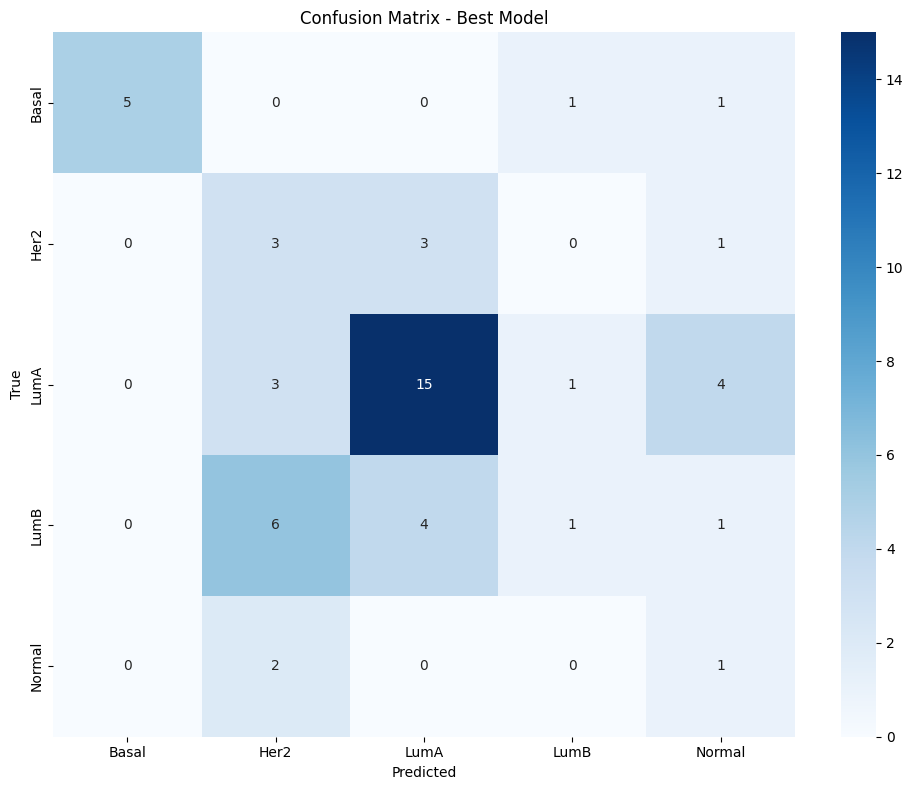

In [10]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, make_scorer

# -------------------------------
# CLASSIFIER
# -------------------------------
def create_classifier(hidden_dim=200, dropout_rate1=0.2, dropout_rate2=0.3, 
                      learning_rate=2e-5, activation='relu', regularization=None):
    inp = Input(shape=(X_train_encoded.shape[1],))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rate1, seed=seed)(x)

    # Choose regularization
    if regularization == 'l1':
        reg = regularizers.l1(1e-14)
    elif regularization == 'l2':
        reg = regularizers.l2(1e-14)
    elif regularization == 'l1_l2':
        reg = regularizers.l1_l2(1e-14, 1e-14)
    else:
        reg = None

    # Activation
    if activation == 'leakyrelu':
        x = Dense(hidden_dim, kernel_regularizer=reg)(x)
        x = LeakyReLU(negative_slope=0.01)(x)
    elif activation == 'relu':
        x = Dense(hidden_dim, kernel_regularizer=reg)(x)
        x = ReLU()(x)
    else:
        x = Dense(hidden_dim, activation='tanh', kernel_regularizer=reg)(x)

    x = BatchNormalization()(x)
    x = Dropout(dropout_rate2, seed=seed)(x)
    out = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap with scikeras KerasClassifier
clf = KerasClassifier(
    model=create_classifier,
    epochs=100,
    verbose=0,
    random_state=seed,
)

# -------------------------------
# RANDOMIZED SEARCH
# -------------------------------
param_dist = {
    'model__hidden_dim': [200],
    'model__dropout_rate1': [0.1, 0.2, 0.3],
    'model__dropout_rate2': [0.1, 0.2, 0.3, 0.4, 0.5],
    'model__learning_rate': [0.01, 0.002, 0.001, 0.0001],
    'model__activation': ['relu', 'tanh', 'leakyrelu'],
    'model__regularization': [None, 'l1', 'l2', 'l1_l2'],
    'batch_size': [16, 32, 64],
}


random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1_weighted',
    cv=2,
    random_state=seed,
    verbose=2
)

# Fit model
start = time.time()
random_search.fit(X_train_encoded, y_train_sm)
end = time.time()
print(f"RandomizedSearchCV completed in {(end-start)/60:.2f} minutes")

# -------------------------------
# EVALUATION
# -------------------------------
best_model = random_search.best_estimator_

# Predict class labels
y_pred_classes = best_model.predict(X_test_encoded)

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred_classes, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test_enc, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Best Model')
plt.tight_layout()
plt.show()


Classification Report (Fixed Classifier):
              precision    recall  f1-score   support

       Basal       1.00      0.71      0.83         7
        Her2       0.21      0.43      0.29         7
        LumA       0.68      0.65      0.67        23
        LumB       0.33      0.08      0.13        12
      Normal       0.12      0.33      0.18         3

    accuracy                           0.48        52
   macro avg       0.47      0.44      0.42        52
weighted avg       0.55      0.48      0.49        52



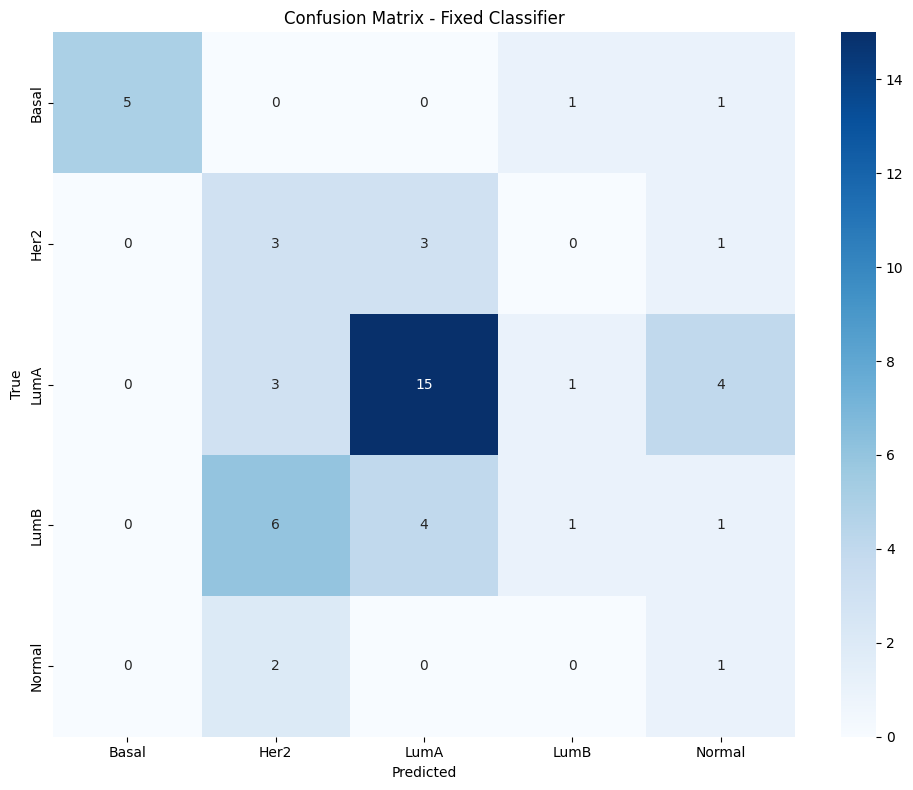

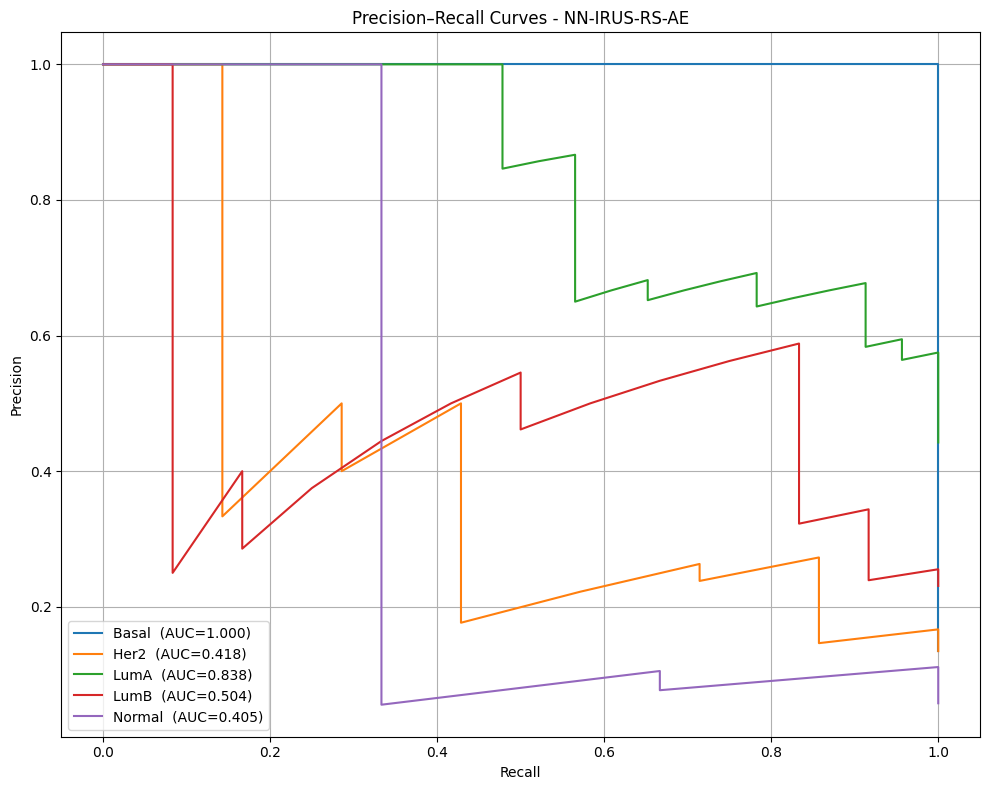


No training history found — skipping accuracy/loss plots.


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve,average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np



# Predict probabilities and classes
y_pred_classes = best_model.predict(X_test_encoded)
y_pred_proba = best_model.predict_proba(X_test_encoded)

# -------------------------------
# CLASSIFICATION REPORT
# -------------------------------
print("\nClassification Report (Fixed Classifier):")
print(classification_report(y_test_enc, y_pred_classes, target_names=le.classes_))

# -------------------------------
# CONFUSION MATRIX
# -------------------------------
cm = confusion_matrix(y_test_enc, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Fixed Classifier')
plt.tight_layout()
plt.show()

# -------------------------------
# PRECISION–RECALL CURVES
# -------------------------------
# Binarize true labels
y_test_binarized = label_binarize(y_test_enc, classes=np.arange(len(le.classes_)))

plt.figure(figsize=(10, 8))

for i, class_name in enumerate(le.classes_):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    auc_score = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f"{class_name}  (AUC={auc_score:.3f})")


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves - NN-IRUS-RS-AE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# TRAINING HISTORY PLOTS (if available)
# -------------------------------
if 'history' in globals():
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("\nNo training history found — skipping accuracy/loss plots.")


In [21]:

# If you used a Scikeras wrapper
print("\nBest Keras model parameters:")
print(best_model.get_params())


Best Keras model parameters:
{'model': <function create_classifier at 0x000001F447949120>, 'build_fn': None, 'warm_start': False, 'random_state': 0, 'optimizer': 'rmsprop', 'loss': None, 'metrics': None, 'batch_size': 32, 'validation_batch_size': None, 'verbose': 0, 'callbacks': None, 'validation_split': 0.0, 'shuffle': True, 'run_eagerly': False, 'epochs': 100, 'class_weight': None, 'model__regularization': None, 'model__learning_rate': 0.002, 'model__hidden_dim': 200, 'model__dropout_rate2': 0.1, 'model__dropout_rate1': 0.1, 'model__activation': 'relu'}


In [20]:
import shap
import lime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, ReLU
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

# ==========================================
# SETTINGS
# ==========================================
original_feature_names = X_train.columns.tolist()

MAX_BACKGROUND = 30
MAX_EXPLAIN = 30
SHAP_BATCH_SIZE = 10
RANDOM_STATE = 42
TOP_K = 10

OUT_DIR = "./explain_results_ir"
os.makedirs(OUT_DIR, exist_ok=True)

# ==========================================
# BUILD AUTOENCODER (EXPLICIT DECODER)
# ==========================================
def build_autoencoder2(input_dim, encoding_dim=500, hidden_dim1=5000, hidden_dim2=2000,
                      l2_reg=1e-14, learning_rate=3e-5):
    # Encoder
    inp = Input(shape=(input_dim,))
    x = Dense(hidden_dim1, kernel_regularizer=regularizers.l2(l2_reg))(inp)
    x = ReLU()(x)
    x = Dense(hidden_dim2, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = ReLU()(x)
    encoded = Dense(encoding_dim, kernel_regularizer=regularizers.l2(l2_reg))(x)
    encoded_act = ReLU()(encoded)

    # Decoder
    x = Dense(hidden_dim2, kernel_regularizer=regularizers.l2(l2_reg))(encoded_act)
    x = ReLU()(x)
    x = Dense(hidden_dim1, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = ReLU()(x)
    decoded = Dense(input_dim, activation='linear')(x)

    autoencoder2 = Model(inp, decoded)
    encoder2 = Model(inp, encoded_act)

    # Explicit decoder model
    encoded_input = Input(shape=(encoding_dim,))
    d = autoencoder2.layers[-6](encoded_input)  # first decoder Dense
    d = autoencoder2.layers[-5](d)             # first ReLU
    d = autoencoder2.layers[-4](d)             # second decoder Dense
    d = autoencoder2.layers[-3](d)             # second ReLU
    d = autoencoder2.layers[-2](d)             # output Dense
    decoder2 = Model(encoded_input, d)

    autoencoder2.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return autoencoder2, encoder2, decoder2

# Assume input_dim is known
autoencoder2, encoder2, decoder2 = build_autoencoder2(input_dim)

# ==========================================
# MODEL EXTRACTION
# ==========================================
print("\n[MODEL] Extracting best Keras model...")
keras_model = None
try:
    keras_model = getattr(best_model, "model_", None)
    if keras_model is None:
        keras_model = best_model.named_steps.get("nn").model_
except Exception:
    keras_model = best_model  # fallback

if keras_model is None:
    raise ValueError("Could not extract Keras model from best_model!")

print("Using Keras model:", type(keras_model))
print(f"Model input shape: {keras_model.input_shape}")

# ==========================================
# USE ENCODED DATA FOR SHAP
# ==========================================
if isinstance(X_train_encoded, pd.DataFrame):
    X_train_arr = X_train_encoded.values
    X_test_arr = X_test_encoded.values
else:
    X_train_arr = X_train_encoded
    X_test_arr = X_test_encoded

feature_names_encoded = [f"Encoded_{i}" for i in range(X_train_arr.shape[1])]
print(f"Using {len(feature_names_encoded)} encoded features")

# ==========================================
# SHAP EXPLANATIONS
# ==========================================
def shap_sample_fallback(X, n, random_state):
    if hasattr(shap, "sample"):
        return shap.sample(X, n, random_state=random_state)
    else:
        idx = np.random.RandomState(random_state).choice(len(X), size=n, replace=False)
        return X[idx]

small_bg = shap_sample_fallback(X_train_arr, min(MAX_BACKGROUND, len(X_train_arr)), RANDOM_STATE)
small_test = shap_sample_fallback(X_test_arr, min(MAX_EXPLAIN, len(X_test_arr)), RANDOM_STATE)

try:
    print("Attempting DeepExplainer...")
    explainer = shap.DeepExplainer(keras_model, small_bg)
    shap_values = explainer.shap_values(small_test, check_additivity=False)
    expected_value = explainer.expected_value
    use_deep = True
except Exception as e:
    print(f"DeepExplainer failed: {e}")
    print("→ Using KernelExplainer with batch processing...")
    def model_wrapper(X):
        return keras_model.predict(X, batch_size=32, verbose=0)
    explainer = shap.KernelExplainer(model_wrapper, small_bg)
    shap_values_list = []
    total_batches = int(np.ceil(len(small_test) / SHAP_BATCH_SIZE))
    for i in range(0, len(small_test), SHAP_BATCH_SIZE):
        batch_end = min(i + SHAP_BATCH_SIZE, len(small_test))
        batch = small_test[i:batch_end]
        batch_shap = explainer.shap_values(batch)
        shap_values_list.append(batch_shap)
        gc.collect()
    if isinstance(shap_values_list[0], list):
        n_classes = len(shap_values_list[0])
        shap_values = [np.vstack([b[c] for b in shap_values_list]) for c in range(n_classes)]
    else:
        shap_values = np.vstack(shap_values_list)
    expected_value = explainer.expected_value
    use_deep = False

del explainer
gc.collect()

if isinstance(shap_values, list):
    shap_values = np.stack([np.array(s) for s in shap_values], axis=2)

# ==========================================
# OVERALL SHAP IMPORTANCE (ENCODED)
# ==========================================
if shap_values.ndim == 3:
    shap_values_overall = np.abs(shap_values).max(axis=2)
else:
    shap_values_overall = np.abs(shap_values)

mean_abs_shap_overall = shap_values_overall.mean(axis=0)
shap_importances_overall = pd.DataFrame({
    "Feature": feature_names_encoded,
    "MeanAbsSHAP_MaxAcrossClasses": mean_abs_shap_overall
}).sort_values(by="MeanAbsSHAP_MaxAcrossClasses", ascending=False)

top_features_overall = shap_importances_overall.head(TOP_K)
top_features_overall.to_csv(os.path.join(OUT_DIR, "top_features_overall_max.csv"), index=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=top_features_overall,
            x="MeanAbsSHAP_MaxAcrossClasses",
            y="Feature",
            palette="Greens_d")
plt.title("Top 10 SHAP Encoded Features (Overall)")
plt.xlabel("Mean |SHAP| Value")
plt.ylabel("Encoded Feature")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "top10_overall_bar.png"), dpi=150)
plt.close()

print("\n=== Top 10 Encoded Features (Overall) ===")
print(top_features_overall)

# ==========================================
# DECODE SHAP VALUES TO ORIGINAL SPACE
# ==========================================
def decode_shap_values(shap_values_encoded, autoencoder, encoding_dim, original_dim):
    """
    Approximate decoding of SHAP values from encoded space to original feature space.
    Uses decoder weights to map SHAP values back.
    
    Parameters:
        shap_values_encoded: np.array, SHAP values in encoded space
        autoencoder: trained Keras autoencoder
        encoding_dim: int, size of encoded vector
        original_dim: int, number of original features
    """
    # Build decoder input
    from tensorflow.keras.layers import Input
    from tensorflow.keras.models import Model

    encoded_input = Input(shape=(encoding_dim,))
    
    # Manually get decoder layers (assume your autoencoder is structured like yours)
    # Here we use all layers after the encoded layer
    decoder_layers = autoencoder.layers[-6:]  # adjust according to your autoencoder
    
    x = encoded_input
    for layer in decoder_layers:
        x = layer(x)
    decoder_model = Model(encoded_input, x)

    # Propagate SHAP values through decoder using weights
    decoded_shap = shap_values_encoded.copy()
    for layer in decoder_layers:
        if hasattr(layer, "get_weights") and len(layer.get_weights()) > 0:
            W, b = layer.get_weights()
            decoded_shap = np.dot(decoded_shap, W)
            # Apply ReLU if exists
            if hasattr(layer, "activation") and layer.activation.__name__ == "relu":
                decoded_shap = np.maximum(decoded_shap, 0)
    
    # Truncate/pad to match original feature size
    decoded_shap = decoded_shap[:, :original_dim]
    return decoded_shap


encoding_dim = 500  # match your autoencoder's encoding_dim
original_dim = X_train.shape[1]

# Decode overall SHAP values
decoded_shap_full = decode_shap_values(shap_values_overall, autoencoder2, encoding_dim, original_dim)
decoded_importance = np.mean(np.abs(decoded_shap_full), axis=0)

decoded_df = pd.DataFrame({
    "Feature": original_feature_names,
    "ApproxMeanAbsSHAP": decoded_importance
}).sort_values(by="ApproxMeanAbsSHAP", ascending=False)

decoded_df.to_csv(os.path.join(OUT_DIR, "decoded_shap_features.csv"), index=False)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=decoded_df.head(TOP_K),
    x="ApproxMeanAbsSHAP",
    y="Feature",
    palette="Blues_d"
)
plt.title("Top 10 Original Features (Decoded SHAP Approximation)")
plt.xlabel("Approx. Mean |SHAP| Value")
plt.ylabel("Original Feature")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "top10_decoded_bar.png"), dpi=150)
plt.close()

# ==========================================
# DECODE SHAP VALUES FOR EACH CLASS
# ==========================================
print("\n[SHAP] Decoding SHAP values to original feature space for each class...")

if shap_values.ndim == 3:
    n_classes = shap_values.shape[2]
    decoded_shap_per_class = []
    
    # Loop through each class and decode separately
    for class_idx in range(n_classes):
        print(f"  Decoding class {class_idx}...")
        class_shap_encoded = shap_values[:, :, class_idx]  # Extract SHAP for this class
        decoded_class_shap = decode_shap_values(class_shap_encoded, autoencoder2, encoding_dim, original_dim)
        decoded_shap_per_class.append(decoded_class_shap)
    
    # Stack back into 3D array: (samples, original_features, classes)
    decoded_shap_3d = np.stack(decoded_shap_per_class, axis=2)
    print(f"  ✓ Decoded SHAP values shape: {decoded_shap_3d.shape}")
else:
    # Single output (binary or regression)
    decoded_shap_3d = decode_shap_values(shap_values, autoencoder2, encoding_dim, original_dim)
    print(f"  ✓ Decoded SHAP values shape: {decoded_shap_3d.shape}")

# ==========================================
# EXTRACT CLASS LABELS FOR SHAP
# ==========================================
try:
    # Use the original LabelEncoder classes
    class_names = le.classes_.tolist()
    print(f"\n[SHAP] Detected class names: {class_names}")
except Exception as e:
    print(f"[SHAP] Could not extract class names: {e}")
    class_names = [f"Class {i}" for i in range(n_classes)]


# ==========================================
# DECODED SHAP SUMMARY PLOTS FOR EACH CLASS
# ==========================================
if decoded_shap_3d.ndim == 3:
    n_classes = decoded_shap_3d.shape[2]
    print(f"\n[SHAP] Creating decoded summary plots for {n_classes} classes...")
    
    # Get original test data for plotting (match the sample size)
    if isinstance(X_test, pd.DataFrame):
        X_test_original = X_test.values[:len(small_test)]
    else:
        X_test_original = X_test[:len(small_test)]
    
    for class_idx in range(n_classes):
        class_label = class_names[class_idx] if class_names else f"Class {class_idx}"
        class_shap_decoded = decoded_shap_3d[:, :, class_idx]
        
        print(f"  Creating plots for {class_label}...")
        
        # Summary plot (beeswarm) - Shows distribution of SHAP values
        plt.figure(figsize=(12, 10))
        shap.summary_plot(
            class_shap_decoded,
            X_test_original,
            feature_names=original_feature_names,
            max_display=TOP_K,
            show=False
        )
        plt.title(f"SHAP Summary Plot (Original Features) - {class_label}", fontsize=14, pad=20)
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"shap_summary_decoded_{class_label.lower().replace(' ', '_')}.png"), 
                   dpi=150, bbox_inches='tight')
        plt.close()
        
        # Bar plot (mean absolute SHAP) - Shows feature importance
        plt.figure(figsize=(10, 8))
        shap.summary_plot(
            class_shap_decoded,
            X_test_original,
            feature_names=original_feature_names,
            max_display=TOP_K,
            plot_type="bar",
            show=False
        )
        plt.title(f"SHAP Feature Importance (Original Features) - {class_label}", fontsize=14, pad=20)
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"shap_bar_decoded_{class_label.lower().replace(' ', '_')}.png"), 
                   dpi=150, bbox_inches='tight')
        plt.close()
        
        # Save class-specific decoded importance to CSV
        mean_abs_shap_class = np.abs(class_shap_decoded).mean(axis=0)
        class_importance_decoded = pd.DataFrame({
            "Feature": original_feature_names,
            "MeanAbsSHAP_Decoded": mean_abs_shap_class
        }).sort_values(by="MeanAbsSHAP_Decoded", ascending=False)
        class_importance_decoded.to_csv(
            os.path.join(OUT_DIR, f"top_features_decoded_{class_label.lower().replace(' ', '_')}.csv"), 
            index=False
        )
        
        print(f"  ✓ {class_label} decoded summary plots saved")
    
    print(f"\n✓ Decoded summary plots for all {n_classes} classes completed")
else:
    # Binary classification or regression
    print("\n[SHAP] Creating decoded summary plot (single output)...")
    
    if isinstance(X_test, pd.DataFrame):
        X_test_original = X_test.values[:len(small_test)]
    else:
        X_test_original = X_test[:len(small_test)]
    
    plt.figure(figsize=(12, 10))
    shap.summary_plot(
        decoded_shap_3d,
        X_test_original,
        feature_names=original_feature_names,
        max_display=TOP_K,
        show=False
    )
    plt.title("SHAP Summary Plot (Original Features)", fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "shap_summary_decoded.png"), dpi=150, bbox_inches='tight')
    plt.close()
    
    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        decoded_shap_3d,
        X_test_original,
        feature_names=original_feature_names,
        max_display=TOP_K,
        plot_type="bar",
        show=False
    )
    plt.title("SHAP Feature Importance (Original Features)", fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "shap_bar_decoded.png"), dpi=150, bbox_inches='tight')
    plt.close()
    
    print("  ✓ Decoded summary plots saved")

print("\n✅ SHAP analysis complete!")
print(f"📁 Results saved to: {OUT_DIR}")
print("📊 Generated files:")
print("   - Encoded feature importance (overall)")
print("   - Decoded feature importance (overall)")
print("   - Per-class decoded summary plots (beeswarm + bar)")
print("   - Per-class decoded feature importance CSVs")
print("\n⚠️  Note: Decoded SHAP values are approximate due to nonlinear decoder layers.")


[MODEL] Extracting best Keras model...
Using Keras model: <class 'keras.src.models.functional.Functional'>
Model input shape: (None, 500)
Using 500 encoded features
Attempting DeepExplainer...


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_3052
Received: inputs=['Tensor(shape=(30, 500))']
  warnings.warn(msg)
C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_3052
Received: inputs=['Tensor(shape=(60, 500))']
  warnings.warn(msg)
C:\Users\mike\AppData\Local\Temp\ipykernel_193908\1003498350.py:163: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v


=== Top 10 Encoded Features (Overall) ===
         Feature  MeanAbsSHAP_MaxAcrossClasses
134  Encoded_134                      0.029050
320  Encoded_320                      0.024513
1      Encoded_1                      0.018952
80    Encoded_80                      0.018397
378  Encoded_378                      0.017629
497  Encoded_497                      0.017599
240  Encoded_240                      0.017409
346  Encoded_346                      0.017142
181  Encoded_181                      0.016462
256  Encoded_256                      0.016418


C:\Users\mike\AppData\Local\Temp\ipykernel_193908\1003498350.py:236: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



[SHAP] Decoding SHAP values to original feature space for each class...
  Decoding class 0...
  Decoding class 1...
  Decoding class 2...
  Decoding class 3...
  Decoding class 4...
  ✓ Decoded SHAP values shape: (30, 19277, 5)

[SHAP] Detected class names: ['Basal', 'Her2', 'LumA', 'LumB', 'Normal']

[SHAP] Creating decoded summary plots for 5 classes...
  Creating plots for Basal...


C:\Users\mike\AppData\Local\Temp\ipykernel_193908\1003498350.py:306: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
C:\Users\mike\AppData\Local\Temp\ipykernel_193908\1003498350.py:321: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


  ✓ Basal decoded summary plots saved
  Creating plots for Her2...


C:\Users\mike\AppData\Local\Temp\ipykernel_193908\1003498350.py:306: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
C:\Users\mike\AppData\Local\Temp\ipykernel_193908\1003498350.py:321: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


  ✓ Her2 decoded summary plots saved
  Creating plots for LumA...


C:\Users\mike\AppData\Local\Temp\ipykernel_193908\1003498350.py:306: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
C:\Users\mike\AppData\Local\Temp\ipykernel_193908\1003498350.py:321: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


  ✓ LumA decoded summary plots saved
  Creating plots for LumB...


C:\Users\mike\AppData\Local\Temp\ipykernel_193908\1003498350.py:306: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
C:\Users\mike\AppData\Local\Temp\ipykernel_193908\1003498350.py:321: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


  ✓ LumB decoded summary plots saved
  Creating plots for Normal...


C:\Users\mike\AppData\Local\Temp\ipykernel_193908\1003498350.py:306: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
C:\Users\mike\AppData\Local\Temp\ipykernel_193908\1003498350.py:321: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


  ✓ Normal decoded summary plots saved

✓ Decoded summary plots for all 5 classes completed

✅ SHAP analysis complete!
📁 Results saved to: ./explain_results_ir
📊 Generated files:
   - Encoded feature importance (overall)
   - Decoded feature importance (overall)
   - Per-class decoded summary plots (beeswarm + bar)
   - Per-class decoded feature importance CSVs

⚠️  Note: Decoded SHAP values are approximate due to nonlinear decoder layers.
